# 🚦 Uber Traffic Dataset - Data Cleaning, Preprocessing & Feature Engineering

## Import Required Libraries

In [12]:
print("Missing values in each column:\n", df.isnull().sum())


Missing values in each column:
 Junction    0
Vehicles    0
ID          0
dtype: int64


In [5]:
# Convert 'DateTime' column to datetime format
df['DateTime'] = pd.to_datetime(df['DateTime'], format='%d/%m/%y %H:%M')
df = df.sort_values('DateTime')
df.set_index('DateTime', inplace=True)
df.head()

,Junction,Vehicles,ID
DateTime,,,
2015-11-01 00:00:00,1,15,20151101001
2015-11-01 00:00:00,2,6,20151101002
2015-11-01 00:00:00,3,9,20151101003
2015-11-01 01:00:00,3,7,20151101013
2015-11-01 01:00:00,1,13,20151101011


In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## Load dataset

In [20]:
df = pd.read_csv('Dataset_Uber Traffic.csv', parse_dates=['DateTime'])

## Preview data

In [21]:
df.head()

,DateTime,Junction,Vehicles,ID
0,2015-01-11 00:00:00,1,15,20151101001
1,2015-01-11 01:00:00,1,13,20151101011
2,2015-01-11 02:00:00,1,10,20151101021
3,2015-01-11 03:00:00,1,7,20151101031
4,2015-01-11 04:00:00,1,9,20151101041


## Exploratory Data Analysis (EDA)

In [22]:
# Basic info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48120 entries, 0 to 48119
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   DateTime  48120 non-null  datetime64[ns]
 1   Junction  48120 non-null  int64         
 2   Vehicles  48120 non-null  int64         
 3   ID        48120 non-null  int64         
dtypes: datetime64[ns](1), int64(3)
memory usage: 1.5 MB


In [23]:
# Check for missing values
df.isnull().sum()

DateTime    0
Junction    0
Vehicles    0
ID          0
dtype: int64

In [48]:
# Summary statistics
df.groupby('Junction')['Vehicles'].describe()

,count,mean,std,min,25%,50%,75%,max
Junction,,,,,,,,
1,14592.0,45.052906,23.008345,5.0,27.0,40.0,59.0,156.0
2,14592.0,14.253221,7.401307,1.0,9.0,13.0,17.0,48.0
3,14592.0,13.694010,10.436005,1.0,7.0,11.0,18.0,180.0
4,4344.0,7.251611,3.521455,1.0,5.0,7.0,9.0,36.0


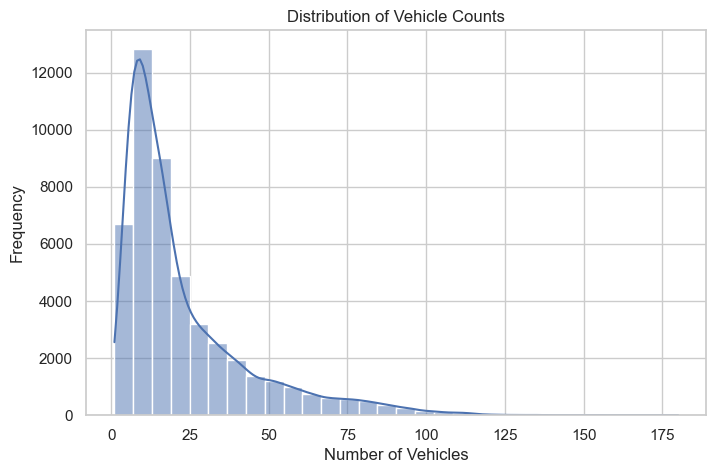

In [26]:
# Distribution of vehicle counts
plt.figure(figsize=(8, 5))
sns.histplot(df['Vehicles'], bins=30, kde=True)
plt.title("Distribution of Vehicle Counts")
plt.xlabel("Number of Vehicles")
plt.ylabel("Frequency")
plt.show()

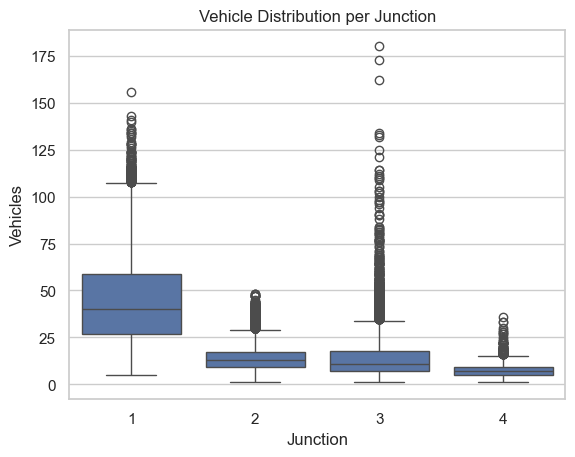

In [45]:
sns.boxplot(data=df, x='Junction', y='Vehicles')
plt.title("Vehicle Distribution per Junction")
plt.show()

## Data Cleaning

In [32]:
# Drop duplicates
df.drop_duplicates(inplace=True)

In [33]:
# Handle missing values if any
df.dropna(inplace=True)

In [34]:
# Ensure data types are correct
df['Junction'] = df['Junction'].astype('category')
df['Vehicles'] = df['Vehicles'].astype(int)

## Aggregate Traffic Data (Hourly by Junction)

In [35]:
# Set datetime index
df.set_index('DateTime', inplace=True)

# Group by hourly intervals and junction
df_hourly = df.groupby([pd.Grouper(freq='H'), 'Junction'])['Vehicles'].sum().reset_index()

# Preview
df_hourly.head()


,DateTime,Junction,Vehicles
0,2015-01-11 00:00:00,1,15
1,2015-01-11 00:00:00,2,6
2,2015-01-11 00:00:00,3,9
3,2015-01-11 00:00:00,4,0
4,2015-01-11 01:00:00,1,13


## Preprocess Data (Normalization)

In [36]:
from sklearn.preprocessing import MinMaxScaler

# Initialize scaler
scaler = MinMaxScaler()

# Apply scaling to vehicle counts
df_hourly['Vehicles_scaled'] = scaler.fit_transform(df_hourly[['Vehicles']])

# Preview
df_hourly.head()

,DateTime,Junction,Vehicles,Vehicles_scaled
0,2015-01-11 00:00:00,1,15,0.083333
1,2015-01-11 00:00:00,2,6,0.033333
2,2015-01-11 00:00:00,3,9,0.050000
3,2015-01-11 00:00:00,4,0,0.000000
4,2015-01-11 01:00:00,1,13,0.072222


## Feature Engineering

In [37]:
# Convert DateTime again if dropped
df_hourly['DateTime'] = pd.to_datetime(df_hourly['DateTime'])

In [38]:
# Time-based features
df_hourly['Hour'] = df_hourly['DateTime'].dt.hour
df_hourly['Day'] = df_hourly['DateTime'].dt.day
df_hourly['Weekday'] = df_hourly['DateTime'].dt.weekday
df_hourly['Month'] = df_hourly['DateTime'].dt.month
df_hourly['IsWeekend'] = df_hourly['Weekday'].apply(lambda x: 1 if x >= 5 else 0)

In [39]:
# Lag features
df_hourly = df_hourly.sort_values(by=['Junction', 'DateTime'])
df_hourly['Lag_1'] = df_hourly.groupby('Junction')['Vehicles'].shift(1)
df_hourly['Lag_24'] = df_hourly.groupby('Junction')['Vehicles'].shift(24)

## Feature Selection – Correlation Matrix

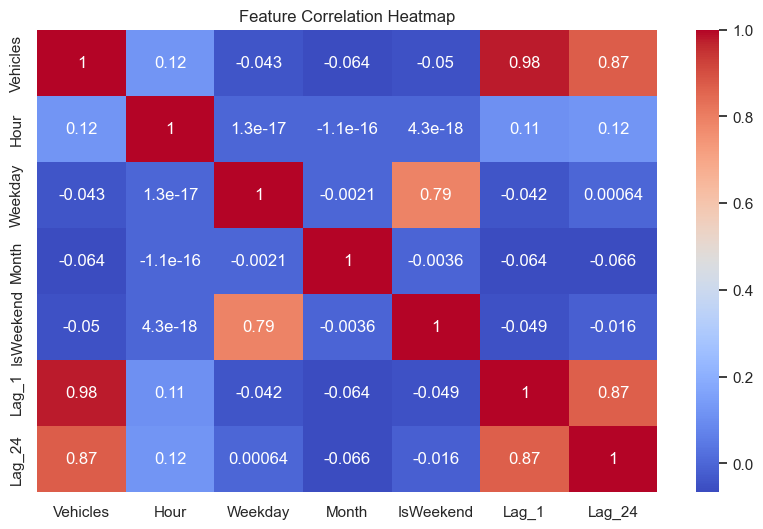

In [40]:
# Correlation heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(df_hourly[['Vehicles', 'Hour', 'Weekday', 'Month', 'IsWeekend', 'Lag_1', 'Lag_24']].corr(), annot=True, cmap='coolwarm')
plt.title("Feature Correlation Heatmap")
plt.show()

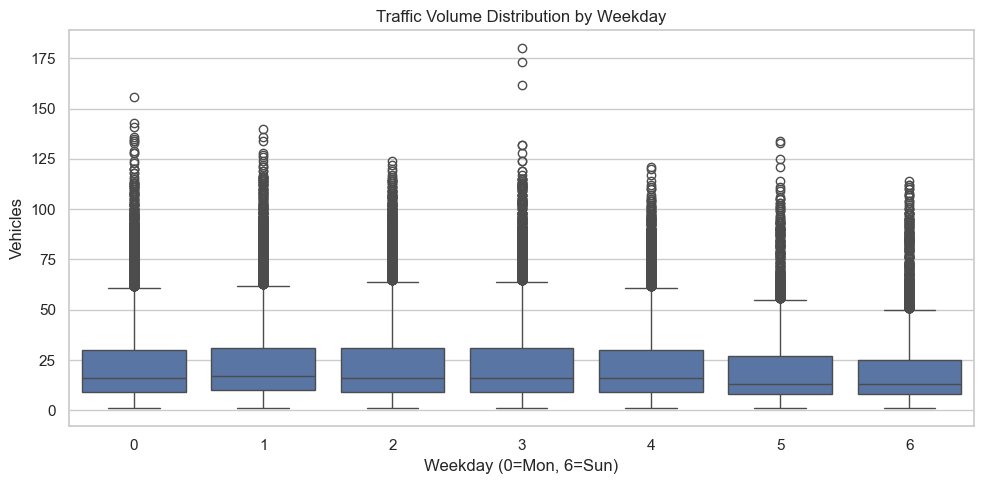

In [41]:
df['Weekday'] = df.index.weekday

plt.figure(figsize=(10,5))
sns.boxplot(x='Weekday', y='Vehicles', data=df)
plt.title("Traffic Volume Distribution by Weekday")
plt.xlabel("Weekday (0=Mon, 6=Sun)")
plt.ylabel("Vehicles")
plt.tight_layout()
plt.show()

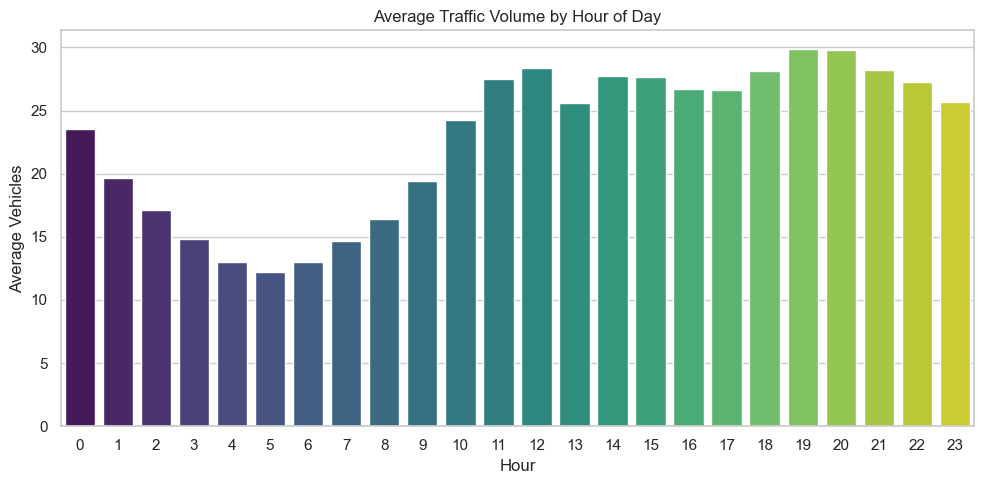

In [42]:
df['Hour'] = df.index.hour

hourly_avg = df.groupby('Hour')['Vehicles'].mean().reset_index()

plt.figure(figsize=(10,5))
sns.barplot(x='Hour', y='Vehicles', data=hourly_avg, palette='viridis')
plt.title("Average Traffic Volume by Hour of Day")
plt.xlabel("Hour")
plt.ylabel("Average Vehicles")
plt.tight_layout()
plt.show()

<Axes: xlabel='Weekday', ylabel='Vehicles'>

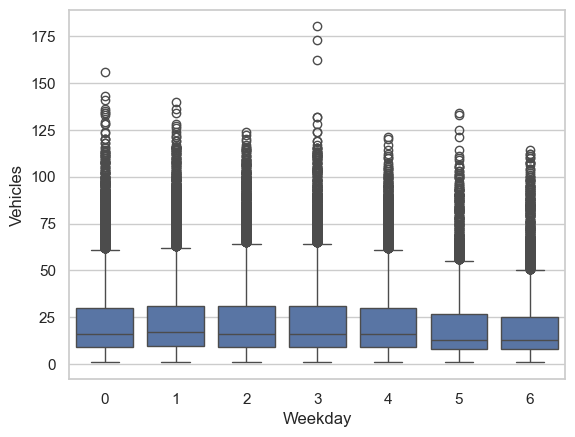

In [49]:
sns.boxplot(x='Weekday', y='Vehicles', data=df)

<Axes: xlabel='Weekday', ylabel='Hour'>

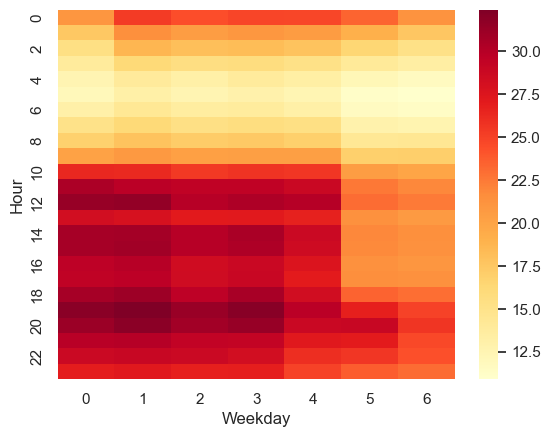

In [50]:
pivot = df.pivot_table(index='Hour', columns='Weekday', values='Vehicles', aggfunc='mean')
sns.heatmap(pivot, cmap="YlOrRd")

In [53]:
df_hourly.head(10)

,DateTime,Junction,Vehicles,Vehicles_scaled,Hour,Day,Weekday,Month,IsWeekend,Lag_1,Lag_24
0,2015-01-11 00:00:00,1,15,0.083333,0,11,6,1,1,NaN,NaN
4,2015-01-11 01:00:00,1,13,0.072222,1,11,6,1,1,15.0,NaN
8,2015-01-11 02:00:00,1,10,0.055556,2,11,6,1,1,13.0,NaN
12,2015-01-11 03:00:00,1,7,0.038889,3,11,6,1,1,10.0,NaN
16,2015-01-11 04:00:00,1,9,0.050000,4,11,6,1,1,7.0,NaN
20,2015-01-11 05:00:00,1,6,0.033333,5,11,6,1,1,9.0,NaN
24,2015-01-11 06:00:00,1,9,0.050000,6,11,6,1,1,6.0,NaN
28,2015-01-11 07:00:00,1,8,0.044444,7,11,6,1,1,9.0,NaN
32,2015-01-11 08:00:00,1,11,0.061111,8,11,6,1,1,8.0,NaN
36,2015-01-11 09:00:00,1,12,0.066667,9,11,6,1,1,11.0,NaN
